In [1]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

### Excercise 1 - modelling height of !Kung people


In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [11]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:compiling stan file /Users/kamilbaradziej/PythonProjects/DataAnalytics/Lab4_Linear_models/height_1_ppc.stan to exe file /Users/kamilbaradziej/PythonProjects/DataAnalytics/Lab4_Linear_models/height_1_ppc
INFO:cmdstanpy:compiled model executable: /Users/kamilbaradziej/PythonProjects/DataAnalytics/Lab4_Linear_models/height_1_ppc
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


### Task 1. Prior predictive checks

- Plot histograms of mu, sigma and simulated height.
- Plot a joint distribution of mu and sigma.
- Check if samples are consistent with priors
- Check if observed data is possible to obtain using priors.

In [12]:
def plt_hist(stan_fit,var_name, bins):
    plt.hist(stan_fit.stan_variable(var_name), bins=bins)
    plt.title("Histogram of var: {}".format(var_name))
    plt.show()
    
def plt_joint_dist(stan_fit, var1, var2):
    plt.scatter(stan_fit.stan_variable(var1), stan_fit.stan_variable(var2))
    plt.title("Joint dist of vars: {}, {}".format(var1, var2))
    plt.show()  

Exception ignored in: <function tqdm.__del__ at 0x7fbde430e8b0>
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/DataAnalytics/lib/python3.8/site-packages/tqdm/std.py", line 1122, in __del__
    self.close()
  File "/usr/local/anaconda3/envs/DataAnalytics/lib/python3.8/site-packages/tqdm/notebook.py", line 261, in close
    self.sp(bar_style='danger')
AttributeError: 'tqdm' object has no attribute 'sp'


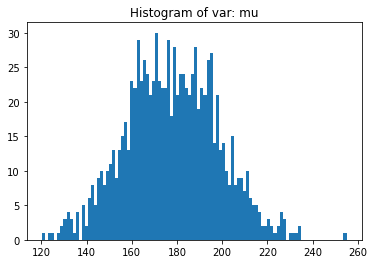

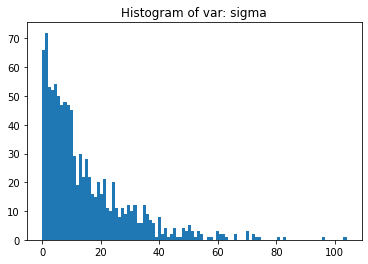

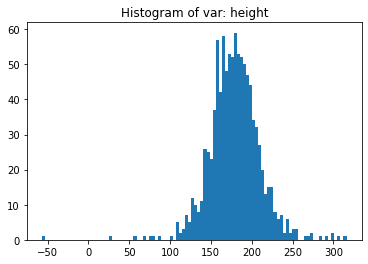

In [13]:
var_names = ['mu', 'sigma', 'height']
bins = 100

for v in var_names:
    plt_hist(sim, v, bins)

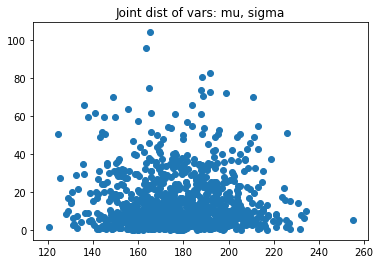

In [14]:
plt_joint_dist(sim, "mu", "sigma")


In [16]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:compiling stan file /Users/kamilbaradziej/PythonProjects/DataAnalytics/Lab4_Linear_models/height_1_fit.stan to exe file /Users/kamilbaradziej/PythonProjects/DataAnalytics/Lab4_Linear_models/height_1_fit
INFO:cmdstanpy:compiled model executable: /Users/kamilbaradziej/PythonProjects/DataAnalytics/Lab4_Linear_models/height_1_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/Users/kamilbaradziej/PythonProjects/DataAnalytics/Lab4_Linear_models/height_1_fit.hpp /Users/kamilbaradziej/PythonProjects/DataAnalytics/Lab4_Linear_models/height_1_fit.stan
Warning in '/Users/kamilbaradziej/PythonProjects/DataAnalytics/Lab4_Linear_models/height_1_fit.stan', line 3, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc

--- Compiling, linking C++ code ---
clang++ -std=c++1y -

In [19]:
fit_model=model_1_fit.sample(data=dict(N=len(d),
                        heights=d.height.values),
                        seed=28052020)
fit_model.summary()

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [2] start processing
INFO:cmdstanpy:Chain [3] start processing
INFO:cmdstanpy:Chain [4] start processing
INFO:cmdstanpy:Chain [1] done processing
INFO:cmdstanpy:Chain [2] done processing
INFO:cmdstanpy:Chain [3] done processing
INFO:cmdstanpy:Chain [4] done processing


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-2100.0,0.022,0.99,-2100.0,-2100.0,-2100.0,2000.0,19000.0,1.0
mu,140.0,0.020,1.20,140.0,140.0,140.0,3500.0,35000.0,1.0
sigma,28.0,0.014,0.84,26.0,28.0,29.0,3700.0,36000.0,1.0
height,140.0,0.440,27.00,93.0,140.0,180.0,3900.0,38000.0,1.0


### Task 2. Model fit and evaluation

- Plot a joint distribution of fitted mu and sigma.
- Plot histograms of data and simulated heights and evaluate the quality of model.

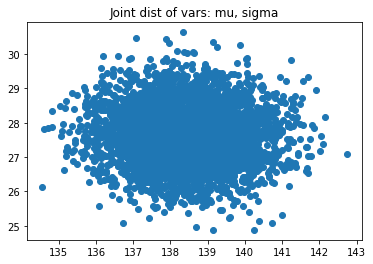

In [21]:
plt_joint_dist(fit, 'mu', 'sigma')


In [24]:
def hist_plot(stan_fit1,var_name1, stan_fit2,var_name2, bins):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.hist(stan_fit1.stan_variable(var_name1), bins=bins)
    ax1.set_title("Histogram of fit: {} and var: {}".format("sim",var_name1))
    ax2.hist(stan_fit2.stan_variable(var_name2), bins=bins)
    ax2.set_title("Histogram of fit: {} and var: {}".format('fit',var_name2))
    plt.tight_layout()
    plt.show()

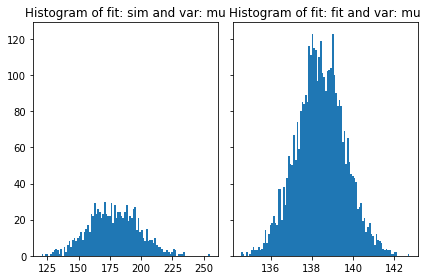

In [25]:
hist_plot(sim, 'mu', fit, 'mu', 100)


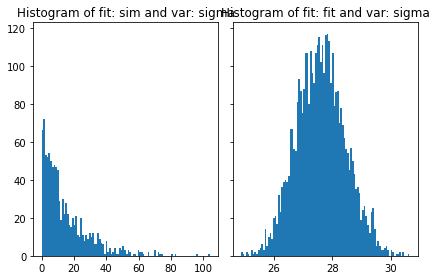

In [26]:
hist_plot(sim, 'sigma', fit, 'sigma', 100)

### Adding predictor to the model - weight

- Create column c_weight in the dataframe containing weights substrated by their mean.

In [28]:
w_mean = d["weight"].mean()
d["c_weight"] = d["weight"] - w_mean

weight = np.linspace(d.c_weight.min(),d.c_weight.max())

print(weight)
print(len(weight))

[-31.35819259 -30.15941374 -28.96063488 -27.76185602 -26.56307716
 -25.36429831 -24.16551945 -22.96674059 -21.76796174 -20.56918288
 -19.37040402 -18.17162516 -16.97284631 -15.77406745 -14.57528859
 -13.37650974 -12.17773088 -10.97895202  -9.78017316  -8.58139431
  -7.38261545  -6.18383659  -4.98505774  -3.78627888  -2.58750002
  -1.38872116  -0.18994231   1.00883655   2.20761541   3.40639426
   4.60517312   5.80395198   7.00273084   8.20150969   9.40028855
  10.59906741  11.79784626  12.99662512  14.19540398  15.39418284
  16.59296169  17.79174055  18.99051941  20.18929826  21.38807712
  22.58685598  23.78563484  24.98441369  26.18319255  27.38197141]
50


In [32]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
data_sim={'N':50, 'weight':weight}

INFO:cmdstanpy:found newer exe file, not recompiling


In [33]:
model_3=model_ppc.sample(data=data_sim, 
                     iter_sampling=1000, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


In [34]:
model_3.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.00,NaN,0.0,0.00,0.00,0.0,NaN,NaN,NaN
alpha,180.00,0.64,20.0,150.00,180.00,210.0,990.0,30000.0,1.0
beta,0.21,0.35,10.0,-17.00,-0.37,17.0,850.0,26000.0,1.0
sigma,15.00,0.45,15.0,0.72,10.00,45.0,1100.0,32000.0,1.0
height[1],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
height[2],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
height[3],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
height[4],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
height[5],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Task 4. Prior predictive checks

- Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

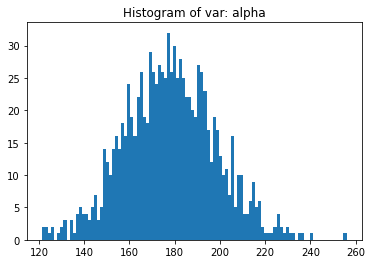

In [36]:
plt_hist(model_3, 'alpha', bins)


### Modifying prior

- If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [37]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')


INFO:cmdstanpy:found newer exe file, not recompiling


In [38]:
model_4=model_ppc.sample(data=data_sim, 
                     iter_sampling=1000, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:Chain [1] start processing
INFO:cmdstanpy:Chain [1] done processing


### Task 5. Prior predictive checks

- Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
- For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?